## Create Violation Dataset

At some point in training the PWM task, around session 200, violations stop being tracked for each animal. Here, I am going to make a new dataframe that only has sessions with violation information for each animal that I can use for future analyses.

In [1]:
import pandas as pd
import numpy as np
import pathlib
import platform
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_context("talk")
MODE = "local"

### Load in 

In [2]:
if platform.system() == "Windows":
    DATA_PATH = pathlib.Path("X:\jbreda\learning_project\data")
else:
    if MODE == "cup":
        DATA_PATH = pathlib.Path("/Volumes/brody/jbreda/learning_project/data")
    elif MODE == "local":
        DATA_PATH = pathlib.Path(
            "/Users/jessbreda/Desktop/github/animal-learning/data/raw"
        )
F_NAME = "rat_behavior.csv"

RAT_DF = pd.read_csv(DATA_PATH / F_NAME)

### Cleaning

In [3]:
RAT_DF["violation"] = RAT_DF.hit.isnull()
RAT_DF.rename(columns={"subject_id": "animal_id"}, inplace=True)
RAT_DF.animal_id = RAT_DF.animal_id.astype("string")
RAT_DF["n_trial"] = RAT_DF.index
RAT_DF["training_stage_cat"] = RAT_DF["training_stage"].astype("category")
RAT_DF["delay"] = RAT_DF.delay.round(2)

### Find viol threshold for each animal

In [4]:
nan_df = RAT_DF[RAT_DF["hit"].isna()]
session_viol_max = nan_df.groupby("animal_id")["session"].max()
session_viol_max

animal_id
W051    196
W060    199
W061    200
W062    199
W065    199
W066    199
W068    200
W072    193
W073    193
W074    200
W075    199
W078    200
W080    200
W081    200
W082    200
W083    200
W088    200
W089    199
W094    199
Name: session, dtype: int64

### Filter DF & save out

In [5]:
def filter_for_viol_sessions(df):
    subject = df["animal_id"].iloc[9]
    last_session_with_nan = session_viol_max.get(subject, -1)
    return df[df["session"] <= last_session_with_nan]


filtered_df = (
    RAT_DF.groupby("animal_id").apply(filter_for_viol_sessions).reset_index(drop=True)
)

In [6]:
filtered_df.groupby("animal_id").session.max() == session_viol_max

animal_id
W051    True
W060    True
W061    True
W062    True
W065    True
W066    True
W068    True
W072    True
W073    True
W074    True
W075    True
W078    True
W080    True
W081    True
W082    True
W083    True
W088    True
W089    True
W094    True
Name: session, dtype: bool

In [113]:
# filtered_df.to_csv(DATA_PATH / "violation_data.csv", index=False)

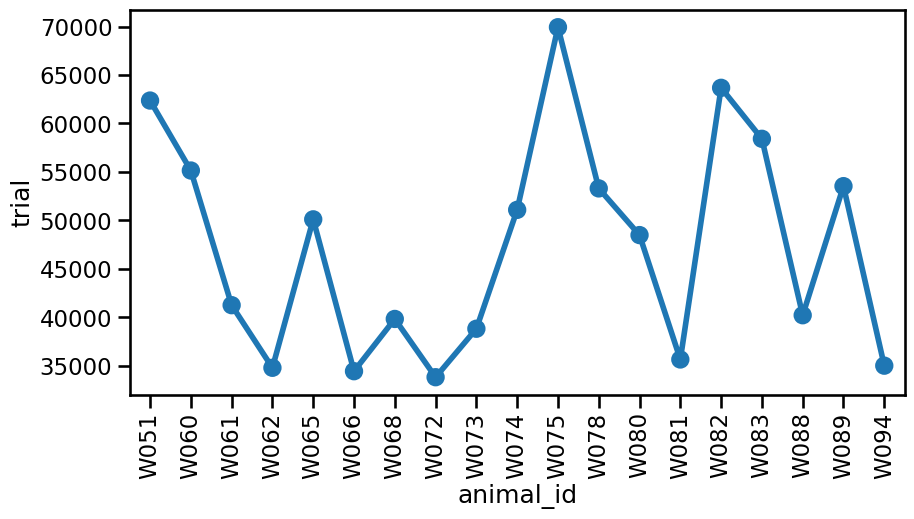

In [7]:
trials = filtered_df.groupby("animal_id").trial.count().reset_index()
fig, ax = plt.subplots(figsize=(10, 5))
sns.pointplot(data=trials, x="animal_id", y="trial")
_ = plt.xticks(rotation=90)

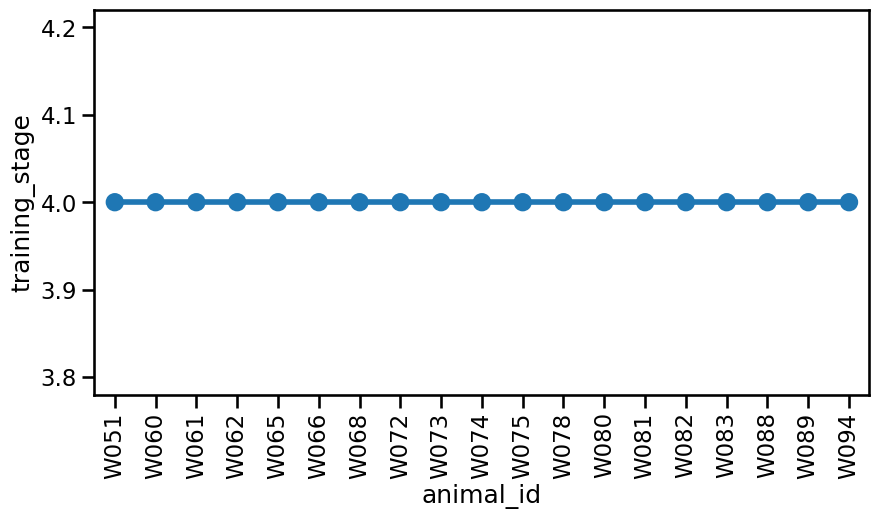

In [8]:
stage = filtered_df.groupby("animal_id").training_stage.max().reset_index()
fig, ax = plt.subplots(figsize=(10, 5))
sns.pointplot(data=stage, x="animal_id", y="training_stage")
_ = plt.xticks(rotation=90)

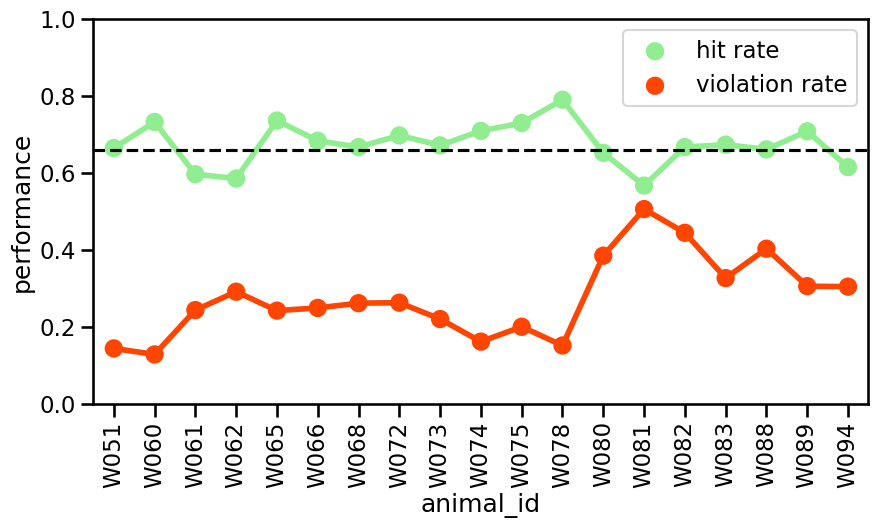

In [9]:
hit = (
    filtered_df.query("training_stage_cat == 4").groupby("animal_id").hit.mean()
).reset_index()
viol = (
    filtered_df.query("training_stage_cat == 4").groupby("animal_id").violation.mean()
).reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
sns.pointplot(data=hit, x="animal_id", y="hit", color="lightgreen", label="hit rate")
sns.pointplot(
    data=viol, x="animal_id", y="violation", color="orangered", label="violation rate"
)
ax.axhline(y=0.66, color="black", linestyle="--")
_ = plt.xticks(rotation=90)

ax.set(ylabel="performance", ylim=(0, 1))
ax.legend()
# ax2 = ax.twinx()
# sns.pointplot(data=trials, x="animal_id", y="trial", ax=ax2)

Given the plots above animals that I would say are "trained" on the task are somewhat limited.

Those would be:**'W060'^, 'W065','W072' 'W074', 'W075'^, 'W078', 'W089'**

Animals that might be close are: **'W051', 'W066', 'W068'^, 'W073', 'W080', 'W082', 'W083', 'W088'**

Animals that have not learned the task: 'W061'%, 'W062'%, 'W081', 'W094'.

^ from previous plotting, not great candidate due to multiple threshold crosses
% from previous plotting, not great candidate for the task, due to not learning

## Determine if animal was "trained" at viol cutoff

In [10]:
# Groupby subject and session, and calculate the mean hit for each subject-session combination
grouped_df = RAT_DF.groupby(["animal_id", "session", "training_stage"]).hit.mean()

# Calculate the rolling mean with a window of 14 sessions for each subject
rolling_mean = grouped_df.rolling(window=14).mean().reset_index()

threshold = 0.70
rolling_mean["crossed_threshold"] = (rolling_mean["hit"].shift() < threshold) & (
    rolling_mean["hit"] >= threshold
)
crossings_count = rolling_mean.groupby("animal_id")["crossed_threshold"].sum()

train_threshold_df = pd.DataFrame({"animal_id": crossings_count.index})
train_threshold_df["avg_hit"] = (
    RAT_DF.query("training_stage_cat == 4").groupby("animal_id").hit.mean().values
)
train_threshold_df["n_crossings"] = crossings_count.values
train_threshold_df["min_cross_sess"] = (
    rolling_mean.groupby("animal_id")
    .apply(lambda x: x.loc[x["crossed_threshold"]].session.min())
    .values
)
train_threshold_df["med_cross_sess"] = (
    rolling_mean.groupby("animal_id")
    .apply(lambda x: x.loc[x["crossed_threshold"]].session.median())
    .values
)
train_threshold_df["max_cross_sess"] = (
    rolling_mean.groupby("animal_id")
    .apply(lambda x: x.loc[x["crossed_threshold"]].session.max())
    .values
)

session_viol_max = session_viol_max.reset_index()

In [11]:
trained_idx = (session_viol_max["session"] - train_threshold_df["max_cross_sess"]) > 0

session_viol_max.animal_id.iloc[trained_idx.values]

4     W065
7     W072
9     W074
11    W078
16    W088
17    W089
Name: animal_id, dtype: string

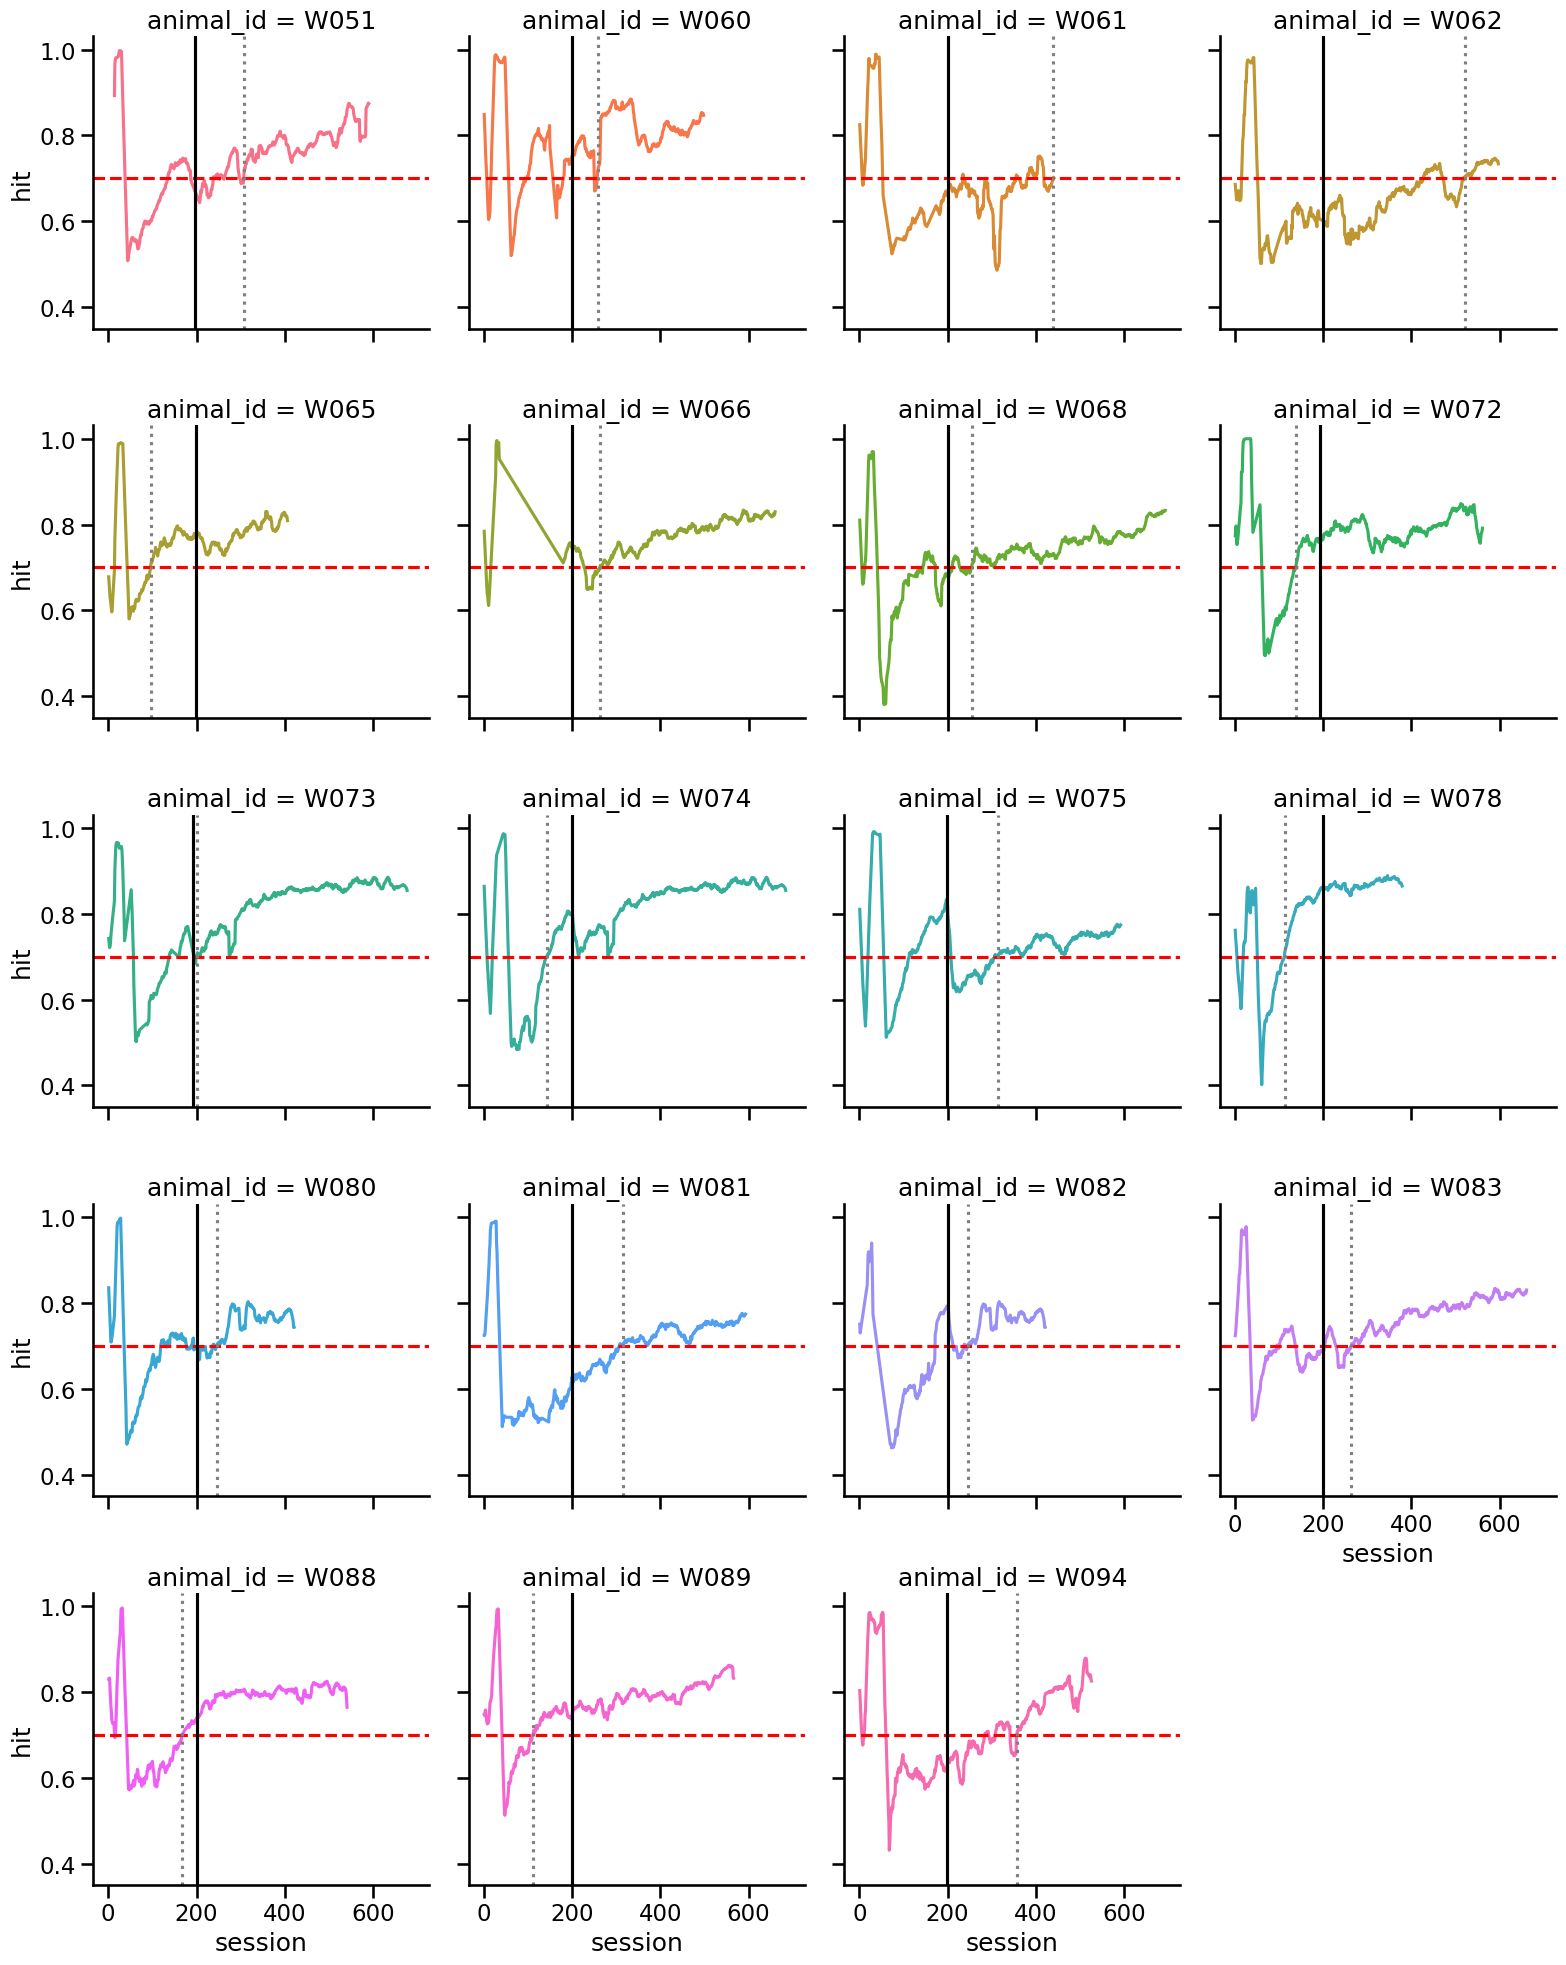

In [12]:
# # Create the facet grid plot
g = sns.FacetGrid(
    data=rolling_mean, col="animal_id", col_wrap=4, hue="animal_id", height=4
)
g.map(sns.lineplot, "session", "hit")
g.map(plt.axhline, y=0.70, color="red", linestyle="--")

for ii, ax in enumerate(g.axes.flat):
    ax.axvline(x=train_threshold_df["max_cross_sess"][ii], color="gray", linestyle=":")
    ax.axvline(x=session_viol_max["session"][ii], color="black", linestyle="-")

Given these visuals the animals I would included in "trained" are:

`W065`, `W072`, `W074`, `W075`, `W078`, `W082`, `W088`, `W089`

I would want to do further analysis for all of them, especially `W073-W075`, `W082` on pair specific performance to verify their training status

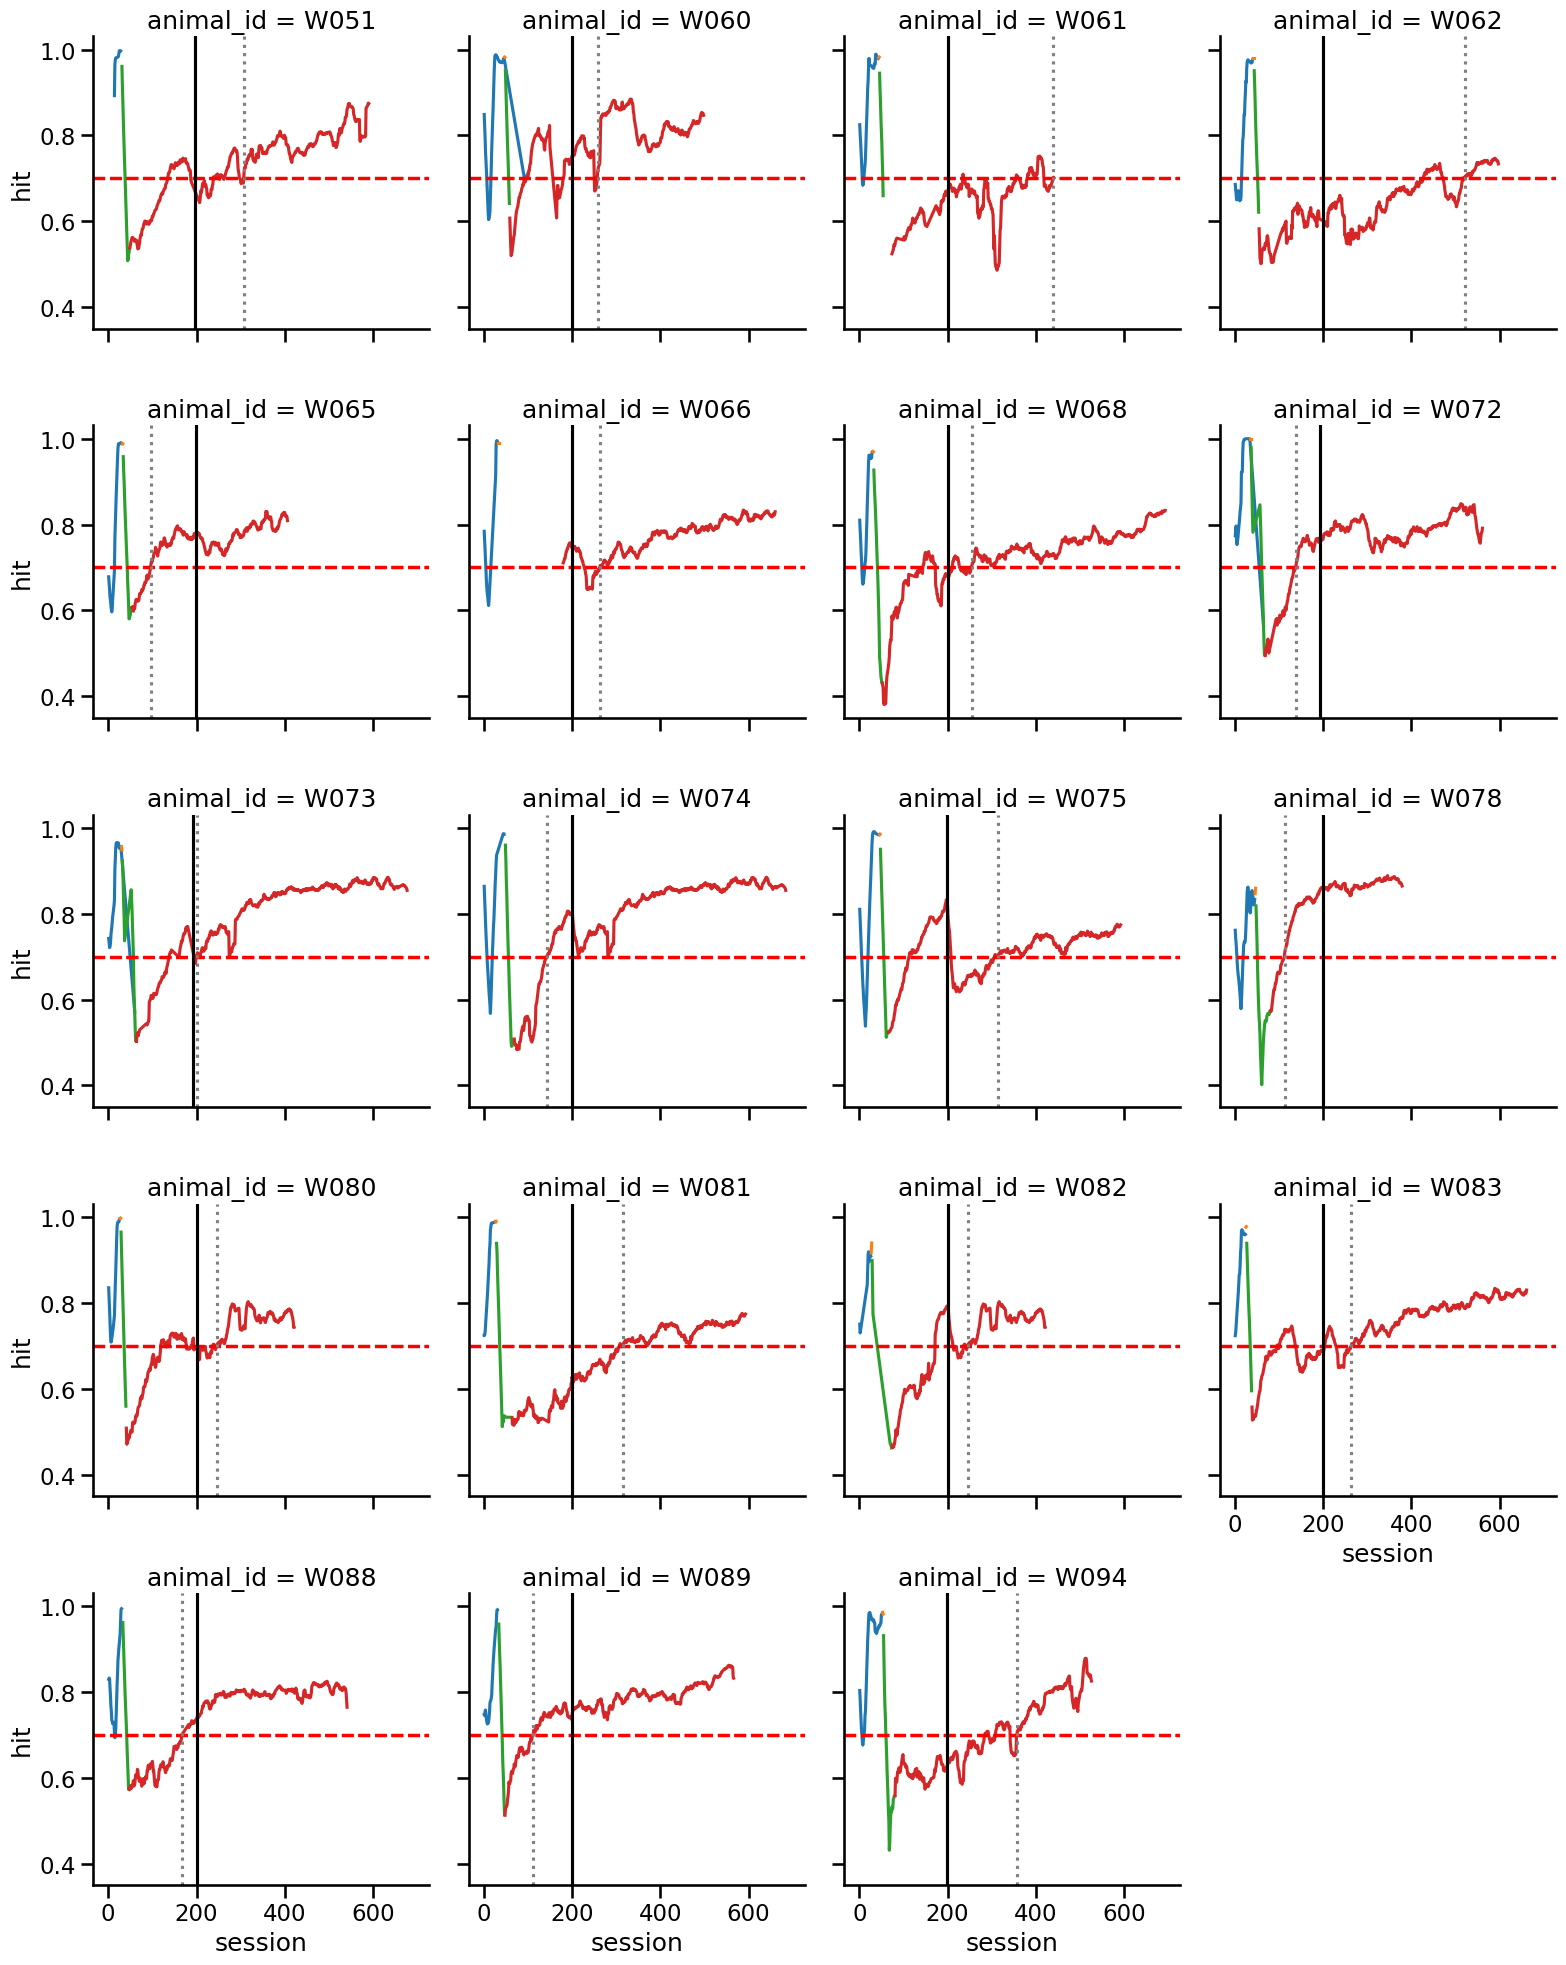

In [15]:
# # Create the facet grid plot
g = sns.FacetGrid(
    data=rolling_mean, col="animal_id", col_wrap=4, hue="training_stage", height=4
)
g.map(sns.lineplot, "session", "hit")
g.map(plt.axhline, y=0.70, color="red", linestyle="--")

for ii, ax in enumerate(g.axes.flat):
    ax.axvline(x=train_threshold_df["max_cross_sess"][ii], color="gray", linestyle=":")
    ax.axvline(x=session_viol_max["session"][ii], color="black", linestyle="-")

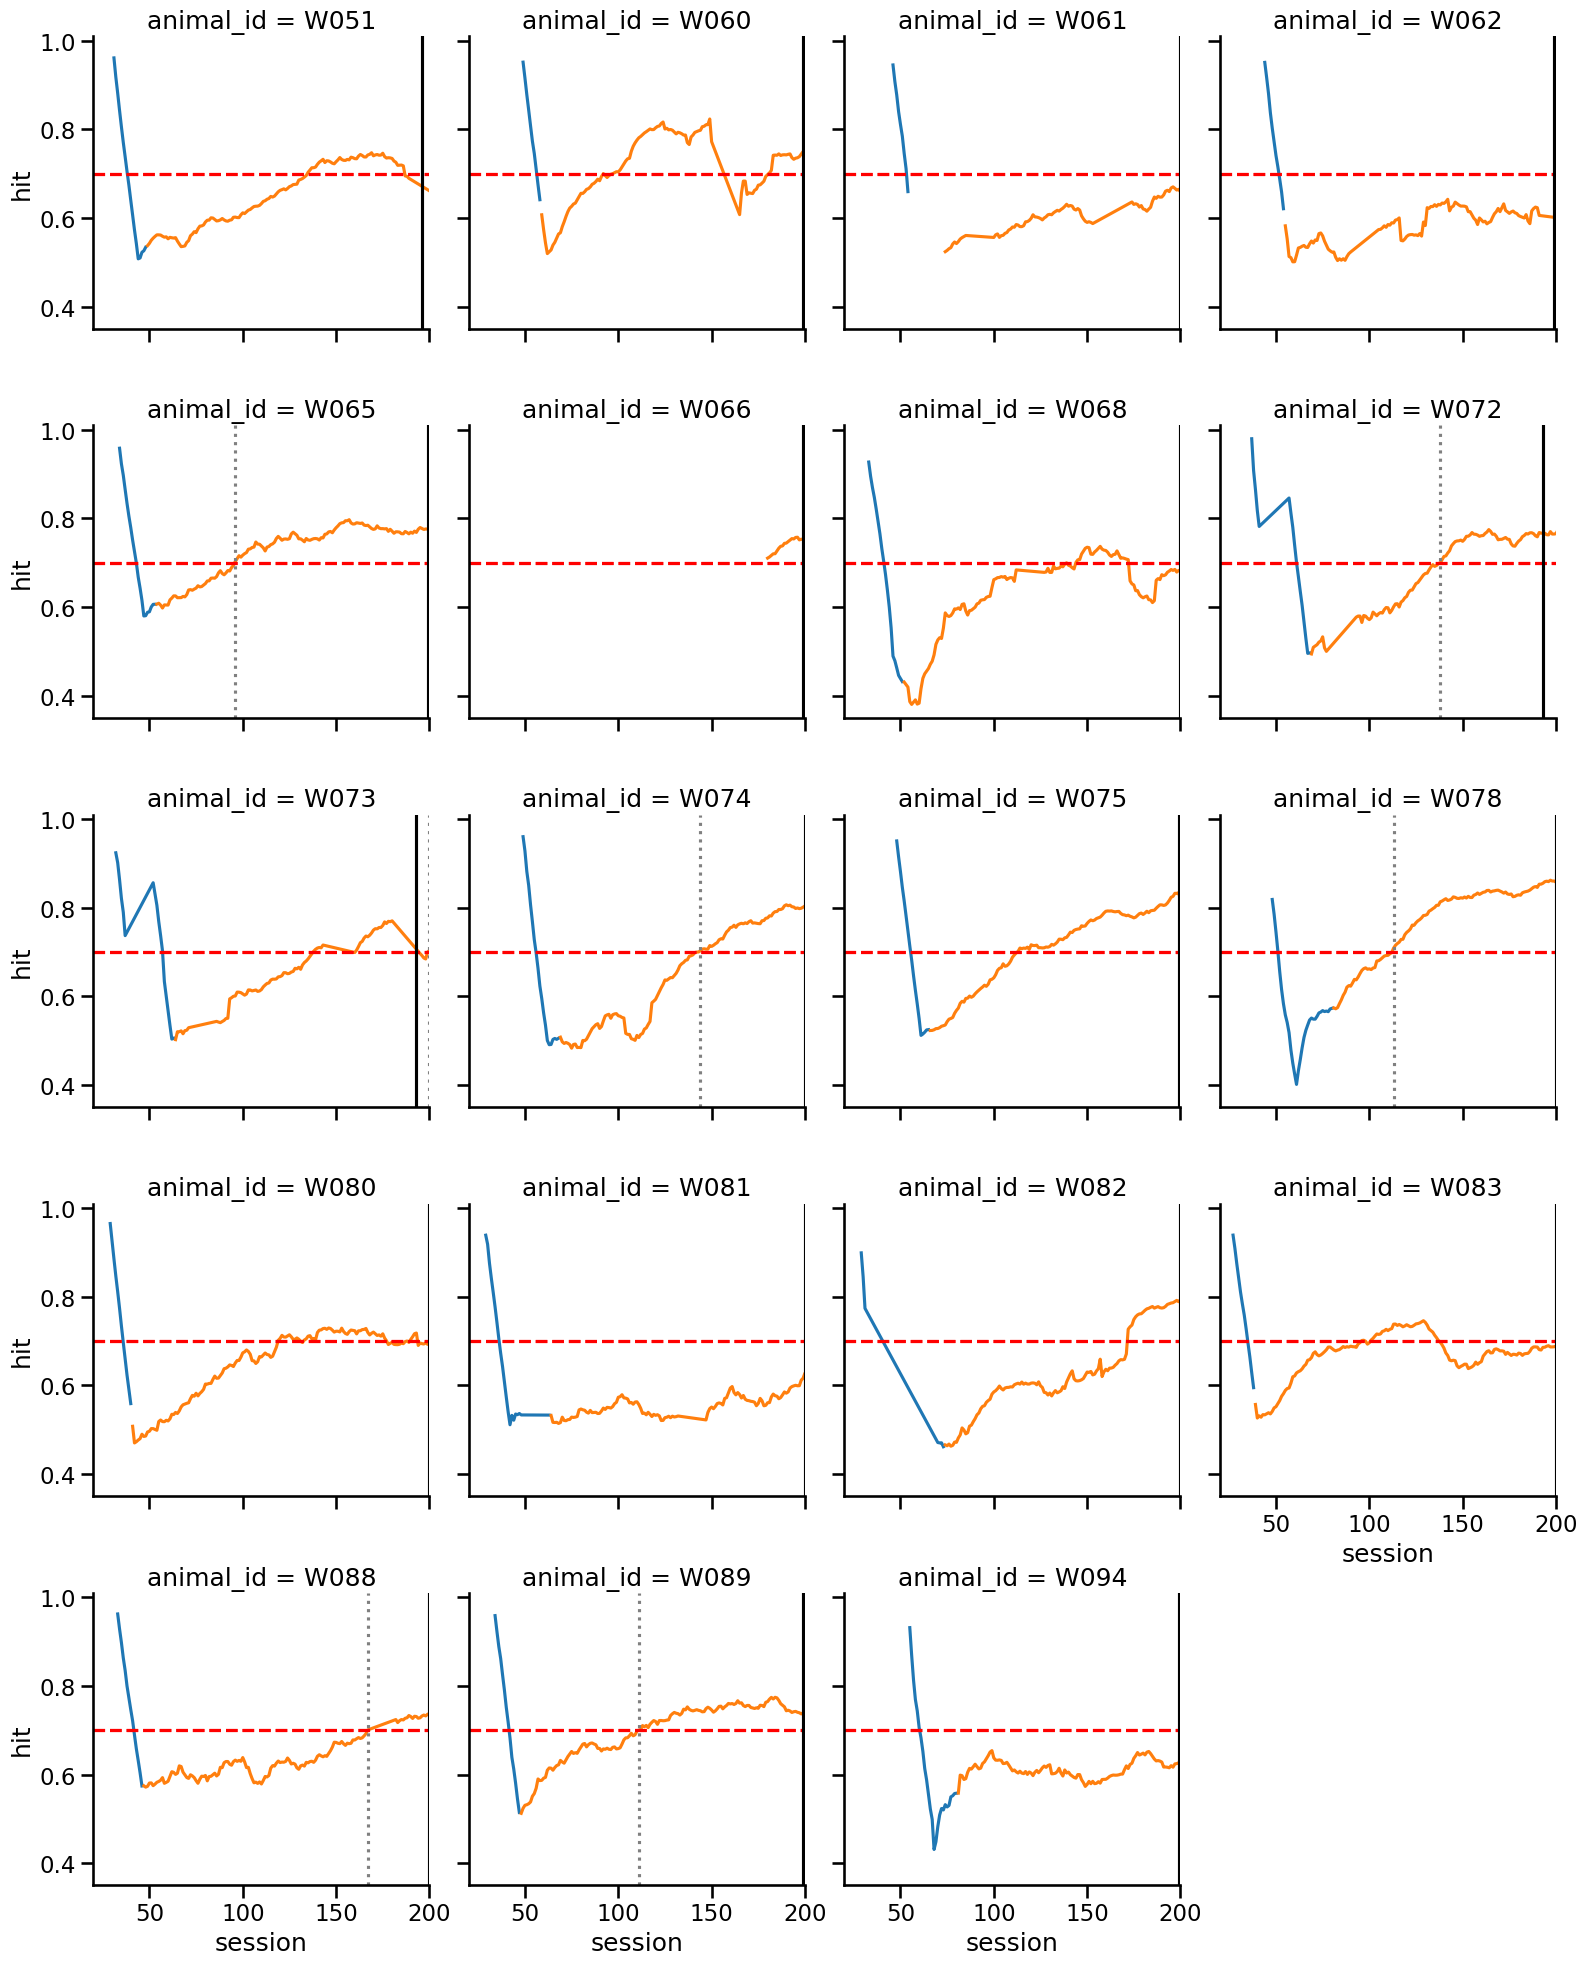

In [20]:
# # Create the facet grid plot
g = sns.FacetGrid(
    data=rolling_mean.query("training_stage > 2"),
    col="animal_id",
    col_wrap=4,
    hue="training_stage",
    height=4,
)
g.map(sns.lineplot, "session", "hit")
g.map(plt.axhline, y=0.70, color="red", linestyle="--")

for ii, ax in enumerate(g.axes.flat):
    ax.axvline(x=train_threshold_df["max_cross_sess"][ii], color="gray", linestyle=":")
    ax.axvline(x=session_viol_max["session"][ii], color="black", linestyle="-")
    ax.set(xlim=(20, 200))